In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
import csv

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)
        
def readCSV(path):
    f = gzip.open(path, 'rt')
    c = csv.reader(f)
    header = next(c)
    for l in c:
        d = dict(zip(header,l))
        yield d['user_id'],d['recipe_id'],d

In [3]:
allRatings = []
for l in readCSV("trainInteractions.csv.gz"):
    allRatings.append(l)
print(len(allRatings))

500000


In [4]:
ratingsTrain = allRatings[:400000]
ratingsValid = allRatings[400000:]
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for u,b,d in ratingsTrain:
    r = int(d['rating'])
    ratingsPerUser[u].append((b,r))
    ratingsPerItem[b].append((u,r))

In [9]:
##################################################
# Rating prediction (CSE258 only)                #
##################################################

In [26]:
trainRatings = [int(r[2]['rating']) for r in ratingsTrain]
globalAverage = sum(trainRatings) * 1.0 / len(trainRatings)

In [27]:
validMSE = 0
for u,b,d in ratingsValid:
    r = int(d['rating'])
    se = (r - globalAverage)**2
    validMSE += se

validMSE /= len(ratingsValid)

print("Validation MSE (average only) = " + str(validMSE))

Validation MSE (average only) = 0.9095362079996616


In [28]:
betaU = {}
betaI = {}
for u in ratingsPerUser:
    betaU[u] = 0

for b in ratingsPerItem:
    betaI[b] = 0

In [29]:
alpha = globalAverage # Could initialize anywhere, this is a guess
print(alpha)

4.5808


In [30]:
def iterate(lamb):
    newAlpha = 0
    for u,b,d in ratingsTrain:
        r = int(d['rating'])
        newAlpha += r - (betaU[u] + betaI[b])
    alpha = newAlpha / len(ratingsTrain)
    for u in ratingsPerUser:
        newBetaU = 0
        for b,r in ratingsPerUser[u]:
            newBetaU += r - (alpha + betaI[b])
        betaU[u] = newBetaU / (lamb + len(ratingsPerUser[u]))
    for b in ratingsPerItem:
        newBetaI = 0
        for u,r in ratingsPerItem[b]:
            newBetaI += r - (alpha + betaU[u])
        betaI[b] = newBetaI / (lamb + len(ratingsPerItem[b]))
    mse = 0
    for u,b,d in ratingsTrain:
        r = int(d['rating'])
        prediction = alpha + betaU[u] + betaI[b]
        mse += (r - prediction)**2
    regularizer = 0
    for u in betaU:
        regularizer += betaU[u]**2
    for b in betaI:
        regularizer += betaI[b]**2
    mse /= len(ratingsTrain)
    return mse, mse + lamb*regularizer

In [31]:
mse,objective = iterate(1)
newMSE,newObjective = iterate(1)
iterations = 2

In [32]:
while iterations < 10 or objective - newObjective > 0.0001:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(1)
    iterations += 1
    print("Objective after "
        + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after "
        + str(iterations) + " iterations = " + str(newMSE))

Objective after 3 iterations = 29309.759129919436
MSE after 3 iterations = 0.4998731768352436
Objective after 4 iterations = 29326.4080671927
MSE after 4 iterations = 0.4996553607856994
Objective after 5 iterations = 29321.34959027473
MSE after 5 iterations = 0.4995517409109471
Objective after 6 iterations = 29313.49400318827
MSE after 6 iterations = 0.4994875148943359
Objective after 7 iterations = 29306.693722716333
MSE after 7 iterations = 0.49944213048685787
Objective after 8 iterations = 29301.33233055546
MSE after 8 iterations = 0.4994079874004639
Objective after 9 iterations = 29297.105603259675
MSE after 9 iterations = 0.49938144123305295
Objective after 10 iterations = 29293.670196341576
MSE after 10 iterations = 0.4993603685475865
Objective after 11 iterations = 29290.76764735018
MSE after 11 iterations = 0.49934337467305595
Objective after 12 iterations = 29288.22462109484
MSE after 12 iterations = 0.4993294812928465
Objective after 13 iterations = 29285.93063163215
MSE afte

In [33]:
validMSE = 0
for u,b,d in ratingsValid:
    r = int(d['rating'])
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if b in betaI:
        bi = betaI[b]
    prediction = alpha + bu + bi
    validMSE += (r - prediction)**2

validMSE /= len(ratingsValid)
print("Validation MSE = " + str(validMSE))

Validation MSE = 0.9052282710310349


In [34]:
betaUs = [(betaU[u], u) for u in betaU]
betaIs = [(betaI[i], i) for i in betaI]
betaUs.sort()
betaIs.sort()

print("Maximum betaU = " + str(betaUs[-1][1]) + ' (' + str(betaUs[-1][0]) + ')')
print("Maximum betaI = " + str(betaIs[-1][1]) + ' (' + str(betaIs[-1][0]) + ')')

Maximum betaU = 87153225 (1.14049340679389)
Maximum betaI = 14725150 (1.750266699895422)


In [35]:
# Better lambda...

iterations = 1
while iterations < 10 or objective - newObjective > 0.0001:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(5)
    iterations += 1
    print("Objective after " + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after " + str(iterations) + " iterations = " + str(newMSE))

Objective after 2 iterations = 28974.497834639038
MSE after 2 iterations = 0.6234995404166844
Objective after 3 iterations = 28424.08543836325
MSE after 3 iterations = 0.6236242862321617
Objective after 4 iterations = 28353.528818019066
MSE after 4 iterations = 0.6237418120987193
Objective after 5 iterations = 28330.186053817717
MSE after 5 iterations = 0.6237867633587479
Objective after 6 iterations = 28319.70734050806
MSE after 6 iterations = 0.6238095402529463
Objective after 7 iterations = 28314.68783733236
MSE after 7 iterations = 0.6238212181081728
Objective after 8 iterations = 28312.351071417947
MSE after 8 iterations = 0.6238267848724618
Objective after 9 iterations = 28311.388343457995
MSE after 9 iterations = 0.6238290320502794
Objective after 10 iterations = 28311.13202460138
MSE after 10 iterations = 0.6238295310141281
Objective after 11 iterations = 28311.23156899055
MSE after 11 iterations = 0.6238291483809962


In [36]:
alpha_ = alpha

In [37]:
validMSE = 0
for u,b,d in ratingsValid:
    r = int(d['rating'])
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if b in betaI:
        bi = betaI[b]
    prediction = alpha + bu + bi
    validMSE += (r - prediction)**2

validMSE /= len(ratingsValid)
print("Validation MSE = " + str(validMSE))

Validation MSE = 0.8436078755864352


In [49]:
predictions = open("HWpredictions_Rated.txt", 'w')
for l in open("stub_Rated.txt"):
    if l.startswith("user_id"):
        predictions.write(l)
        continue
    u,b = l.strip().split('-')
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if b in betaI:
        bi = betaI[b]
    _ = predictions.write(u + '-' + b + ',' + str(alpha + bu + bi) + '\n')

predictions.close()

### Latent factor model (Surprise)¶

In [8]:
import gzip
import random
import scipy
import tensorflow as tf
from collections import defaultdict
from surprise import SVD, Reader, Dataset, Trainset
from surprise.model_selection import train_test_split

In [9]:
#allRatings = []
predictions = open("trainInteractions_suprise.csv", 'w')
for l in readCSV("trainInteractions.csv.gz"):
    #print(l)
    predictions.write(l[2]['user_id'] + ',' + l[2]['recipe_id'] + ',' + l[2]['rating'] + '\n')
predictions.close()

#print(allRatings[0])

In [10]:
dataDir = '~/Desktop/CSE258/assignment1/'
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_file(dataDir + "trainInteractions_suprise.csv", reader=reader)

In [11]:
model = SVD()
trainset, validset = train_test_split(data, test_size=.25)

In [12]:
model.fit(trainset)
predictions = model.test(validset)


In [13]:
predictions[0].est

5

In [14]:
predictions[0]

Prediction(uid='70295963', iid='13248449', r_ui=5.0, est=5, details={'was_impossible': False})

In [15]:
model.predict(uid='97678064', iid='27701084')

Prediction(uid='97678064', iid='27701084', r_ui=None, est=4.456433329108544, details={'was_impossible': False})

In [16]:
sse = 0
for p in predictions:
    sse += (p.r_ui - p.est)**2

print(sse / len(predictions))

0.8367313627797117


In [17]:
predictions = open("LatentFactorModel_Rated.txt", 'w')
for l in open("stub_Rated.txt"):
    if l.startswith("user_id"):
        predictions.write(l)
        continue
    u,b = l.strip().split('-')
    pred = model.predict(uid=u, iid=b)
    predictions.write(u + '-' + b + ',' + str(pred.est) + '\n')

predictions.close()

### Baselines.py

In [5]:
import gzip
from collections import defaultdict
from sklearn import linear_model
import csv

def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    c = csv.reader(f)
    header = next(c)
    for l in c:
        d = dict(zip(header,l))
        yield d['user_id'],d['recipe_id'],d

In [6]:
### Rating baseline: compute averages for each user, or return the global average if we've never seen the user before

allRatings = []
userRatings = defaultdict(list)

for user,recipe,d in readCSV("trainInteractions.csv.gz"):
  r = int(d['rating'])
  allRatings.append(r)
  userRatings[user].append(r)

globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for u in userRatings:
  userAverage[u] = sum(userRatings[u]) / len(userRatings[u])

predictions = open("predictions_Rated.txt", 'w')
for l in open("stub_Rated.txt"):
  if l.startswith("user_id"):
    #header
    predictions.write(l)
    continue
  u,i = l.strip().split('-')
  if u in userAverage:
    predictions.write(u + '-' + i + ',' + str(userAverage[u]) + '\n')
  else:
    predictions.write(u + '-' + i + ',' + str(globalAverage) + '\n')

predictions.close()

In [7]:
validMSE = 0
for u,b,d in ratingsValid:
    r = int(d['rating'])
    prediction = globalAverage
    if u in userAverage:
        prediction = userAverage[u]
    validMSE += (r - prediction)**2

validMSE /= len(ratingsValid)
print("Validation MSE = " + str(validMSE))

Validation MSE = 0.7689307678860396


### Mean of baseline and latent factor model

In [21]:
predictions = open("predictions_mean_Rated.txt", 'w')
for l in open("stub_Rated.txt"):
  if l.startswith("user_id"):
    #header
    predictions.write(l)
    continue
  u,i = l.strip().split('-')
  pred = model.predict(uid=u, iid=b)
  if u in userAverage:
    predictions.write(u + '-' + i + ',' + str((userAverage[u]+pred.est)/2)+ '\n')
  else:
    predictions.write(u + '-' + i + ',' + str((globalAverage+pred.est)/2) + '\n')

predictions.close()

In [20]:
validMSE = 0
for u,b,d in ratingsValid:
    r = int(d['rating'])
    prediction = (globalAverage+pred.est)/2
    if u in userAverage:
        prediction = (userAverage[u]+pred.est)/2
    validMSE += (r - prediction)**2

validMSE /= len(ratingsValid)
print("Validation MSE = " + str(validMSE))

Validation MSE = 0.8068564418316578


### Bayesan Personalized Ranking

In [105]:
userIDs,itemIDs = {},{}

for user,recipe,d in readCSV("trainInteractions.csv.gz"):
    u,i = d['user_id'],d['recipe_id']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

nUsers,nItems = len(userIDs),len(itemIDs)
nUsers,nItems

(13533, 151462)

In [108]:
Xiu = scipy.sparse.lil_matrix((nItems, nUsers))
for user,recipe,d in readCSV("trainInteractions.csv.gz"):
    u,i = d['user_id'],d['recipe_id']
    Xiu[itemIDs[d['recipe_id']],userIDs[d['user_id']]] = 1
    
Xui = scipy.sparse.csr_matrix(Xiu.T)

In [109]:
model = bpr.BayesianPersonalizedRanking(factors = 5)
model.fit(Xiu)

  0%|          | 0/100 [00:00<?, ?it/s]

In [118]:
recommended = model.recommend(10, Xui)
recommended

[(22426, 3.5211954),
 (62078, 3.4570208),
 (16345, 3.411941),
 (24198, 3.3494496),
 (4569, 3.3443437),
 (20400, 3.3059978),
 (22092, 3.2772527),
 (8810, 3.2588162),
 (10982, 3.2553535),
 (17671, 3.2341893)]

In [117]:
related = model.similar_items(76838)
related

[(76838, 0.9999999),
 (0, 0.9952802),
 (1876, 0.98914796),
 (76931, 0.9853462),
 (93319, 0.9831609),
 (57613, 0.98255026),
 (92938, 0.98157287),
 (90758, 0.980197),
 (64739, 0.97917026),
 (151195, 0.9788191)]

In [111]:
itemFactors = model.item_factors
userFactors = model.user_factors
itemFactors[0]

array([ 0.12505014, -0.61250174,  0.59136564,  0.05454955,  0.44120973,
        0.13717534], dtype=float32)

In [159]:
import numpy as np

def bpr_made_prediction(threshold):
    scores = []
    predictions = open("prediction_bpr_Made_%f.txt"%threshold, 'w')
    for l in open("stub_Made.txt"):
        if l.startswith("user_id"):
            predictions.write(l)
            continue
        u,i = l.strip().split('-')
        if (u not in userIDs.keys()) or (i not in itemIDs.keys()):
            predictions.write(u + '-' + i + ",0\n")
            scores.append(0)
            continue
        itemFactor = itemFactors[itemIDs[i]]
        userFactor = userFactors[userIDs[u]]
        score = np.dot(userFactor, itemFactor)
        scores.append(score)
        #print(score)
        if score>=threshold:
            predictions.write(u + '-' + i + ",1\n")
        else:
            predictions.write(u + '-' + i + ",0\n")

    predictions.close()

for threshold in [-4,-3,-2,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,2,3,4]:
    bpr_made_prediction(threshold)

In [164]:
kaggle_score = {}
kaggle_score[-4]=0.54810
kaggle_score[-3]=0.54790
kaggle_score[-2]=0.54860
kaggle_score[-1]=0.55960
kaggle_score[-0.75]=0.56770
kaggle_score[-0.5]=0.58090
kaggle_score[-0.25]=0.59930
kaggle_score[0]=0.62110
kaggle_score[0.25]=0.63890
kaggle_score[0.5]=0.63740
kaggle_score[0.75]= 0
kaggle_score[1]=0.59950
kaggle_score[2]=0.52669
kaggle_score[3]= 0
kaggle_score[4]=0.50330
kaggle_score

{-4: 0.5481,
 -3: 0.5479,
 -2: 0.5486,
 -1: 0.5596,
 -0.75: 0.5677,
 -0.5: 0.5809,
 -0.25: 0.5993,
 0: 0.6211,
 0.25: 0.6389,
 0.5: 0.6374,
 0.75: 0,
 1: 0.5995,
 2: 0.52669,
 3: 0,
 4: 0.5033}

In [151]:
print(min(scores))
print(max(scores))

-6.2406373
3.81858


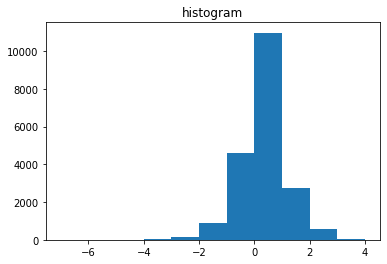

In [153]:
from matplotlib import pyplot as plt 
import numpy as np  
   
a = np.array([22,87,5,43,56,73,55,54,11,20,51,5,79,31,27]) 
plt.hist(scores,bins = [-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4]) 
plt.title("histogram") 
plt.show()